In [43]:
import math
import numpy as np
from keras.models import load_model
from keras import models
import keras.backend as K
from keras.layers import Conv2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path: sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
from gradcam_utils import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Obtain image features for each class in both Training and Test data

## Load Pretrained Model

In [44]:
model = load_model('save/texturenet.h5')
for l in model.layers:
    print(l.name)

conv2d_1
conv2d_2
max_pooling2d_1
conv2d_3
conv2d_4
max_pooling2d_2
conv2d_5
conv2d_6
conv2d_7
global_average_pooling2d_1
dense_1


## Load full training image batch

In [45]:
DATASET_ROOT = 'data/train'
GT_ROOT = 'data/ground_truth'
CLASSES = ['carpet', 'grid', 'leather', 'tile', 'wood']

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(DATASET_ROOT,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=(224, 224),
                                                    batch_size=1266,
                                                    shuffle=False,
                                                    classes=CLASSES)
unique, counts = np.unique(train_generator.labels, return_counts=True)
print(dict(zip(CLASSES, counts)))

Found 1266 images belonging to 5 classes.
{'wood': 247, 'carpet': 280, 'leather': 245, 'grid': 264, 'tile': 230}


In [46]:
train_input,y = train_generator.next()
print(train_input.shape)
cur_batch_sz = 1266

(1266, 224, 224, 3)


## Get the set of train images for each class by getting a binary index mask 

In [47]:
train_carpet_idx = np.full(len(train_generator.filenames),False)
train_grid_idx = np.full(len(train_generator.filenames),False)
train_leather_idx = np.full(len(train_generator.filenames),False)
train_tile_idx = np.full(len(train_generator.filenames),False)
train_wood_idx = np.full(len(train_generator.filenames),False)       
for i in range(len(train_generator.filenames)):
    for j in range(len(train_generator.filenames[i])):
        if train_generator.filenames[i][j]== "/":
            break
    correct_class = train_generator.filenames[i][0:j]
    if correct_class == "carpet":
        train_carpet_idx[i] = True
    if correct_class == "grid":
        train_grid_idx[i] = True
    if correct_class == "leather":
        train_leather_idx[i] = True
    if correct_class == "tile":
        train_tile_idx[i] = True
    if correct_class == "wood":
        train_wood_idx[i] = True

**sanity check**

In [48]:
print(len(train_input[train_carpet_idx]))
print(len(train_input[train_grid_idx]))
print(len(train_input[train_leather_idx]))
print(len(train_input[train_tile_idx]))
print(len(train_input[train_wood_idx]))

280
264
245
230
247


## Load full testing image batch

In [49]:
DATASET_ROOT = 'data/test'
GT_ROOT = 'data/ground_truth'
CLASSES = ['carpet', 'grid', 'leather', 'tile', 'wood']

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(DATASET_ROOT,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=(224, 224),
                                                    batch_size=515,
                                                    shuffle=False,
                                                    classes=CLASSES)
unique, counts = np.unique(test_generator.labels, return_counts=True)
print(dict(zip(CLASSES, counts)))

Found 515 images belonging to 5 classes.
{'wood': 79, 'carpet': 117, 'leather': 124, 'grid': 78, 'tile': 117}


In [50]:
test_input,y = test_generator.next()
print(test_input.shape)
cur_batch_sz = 515

(515, 224, 224, 3)


## Get the set of test images for each class by getting a binary index mask

In [51]:
test_carpet_idx = np.full(len(test_generator.filenames),False)
test_grid_idx = np.full(len(test_generator.filenames),False)
test_leather_idx = np.full(len(test_generator.filenames),False)
test_tile_idx = np.full(len(test_generator.filenames),False)
test_wood_idx = np.full(len(test_generator.filenames),False)       
for i in range(len(test_generator.filenames)):
    for j in range(len(test_generator.filenames[i])):
        if test_generator.filenames[i][j]== "/":
            break
    correct_class = test_generator.filenames[i][0:j]
    if correct_class == "carpet":
        test_carpet_idx[i] = True
    if correct_class == "grid":
        test_grid_idx[i] = True
    if correct_class == "leather":
        test_leather_idx[i] = True
    if correct_class == "tile":
        test_tile_idx[i] = True
    if correct_class == "wood":
        test_wood_idx[i] = True

**Sanity check**

In [52]:
print(len(test_input[test_carpet_idx]))
print(len(test_input[test_grid_idx]))
print(len(test_input[test_leather_idx]))
print(len(test_input[test_tile_idx]))
print(len(test_input[test_wood_idx]))

117
78
124
117
79


## Get learned features for each class in training data and test data

In [11]:
defect_result = np.zeros(len(test_input))
defect_pred_score = np.zeros(len(test_input))


## ---------------------Run from this part for each class by editing the class name in train_idx and test_idx -----------------##

In [51]:
train_idx = train_wood_idx
test_idx = test_wood_idx

In [52]:
print(len(train_input[train_idx]))
print(len(test_input[test_idx]))

264
78


## Getting learned representations at topmost layer for input images of a class in both the test and training data ##

In [53]:
layer_activation_model = models.Model(inputs=model.input, outputs=model.layers[7].output)##Choosing topmost layer here
layer_output = layer_activation_model.predict(np.append(train_input[train_idx],test_input[test_idx],axis=0))

In [54]:
layer_out_vec = np.reshape(layer_output,(len(layer_output),56*56*256))
print(layer_out_vec.shape)

(342, 802816)


## Training image features are used for fitting the novelty detection estimator and anomalies are predicted in test images

In [55]:
clf = LocalOutlierFactor(n_neighbors=30, novelty=True, contamination=0.5)
clf.fit(layer_out_vec[0:len(train_input[train_idx])])
result = clf.predict(layer_out_vec[len(train_input[train_idx]):(len(test_input[test_idx])+len(train_input[train_idx]))])
for i in range(len(result)):
    if result[i] == 1:
        result[i] = 0
    if result[i] == -1:
        result[i] = 1
print(result)

[0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0
 1 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1
 0 1 1 1]


**get a binary index masks for defective images**

In [56]:
defect_idx = np.full(len(result),False)
for i in range(len(result)):
    if result[i] == 1:
        defect_idx[i] = True
print(defect_idx)

[False  True  True False  True  True False  True  True  True  True False
 False  True False  True False False False False  True False  True False
 False  True  True False False False False False False False  True  True
 False  True  True False False False False False  True False False  True
 False False  True  True False False False False  True  True  True  True
  True False False False  True  True  True  True False False False  True
  True  True False  True  True  True]


In [38]:
pred_score = clf.decision_function(layer_out_vec[len(train_input[train_idx]):(len(test_input[test_idx])+len(train_input[train_idx]))])

**Storing individual class' defect result and prediction scores to overall result**

In [18]:
defect_result[test_idx] = result
defect_pred_score[test_idx] = pred_score

## Calculating AUC and plotting ROC for defect detection of each texture class 

**Get ground truth for defect classification 1 = defect**

In [17]:
defect_grdtruth = np.ones(len(test_input))
for i in range(len(test_generator.filenames)):
    if "good" in test_generator.filenames[i]:
        defect_grdtruth[i] = 0;

AUC: 0.967


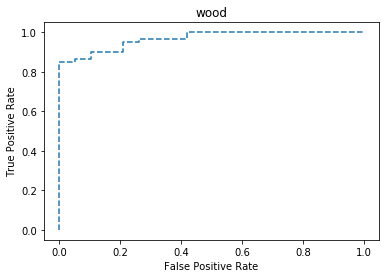

In [159]:
auc = roc_auc_score(defect_grdtruth[test_idx], -1*defect_pred_score[test_idx])
print('AUC: %.3f' % auc)
fpr, tpr, _ = roc_curve(defect_grdtruth[test_idx],-1*defect_pred_score[test_idx])
plt.plot(fpr, tpr, linestyle='--')
plt.title("wood")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Getting Grad-Cam for images classified as defect by novelty detection

In [39]:
alpha, layer = get_grad_cam_weights(model, np.zeros((1, 224, 224, 3)))

(256, 5)


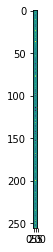

In [40]:
print(alpha.shape)
plt.imshow(alpha)

In [207]:
print(layer)

conv2d_7


In [60]:
#start_idx = 0
#end_idx = 514
#cur_batch_sz = end_idx - start_idx + 1
#img_batch = read_batch(test_generator.directory, test_generator.filenames[start_idx:end_idx + 1], cur_batch_sz,
#                           (224, 224))

## Ignoring non-maximum classes getting grad cam of one texture class with images classified as defective

In [57]:
pred_scores = model.predict(test_input[test_idx][defect_idx])

In [58]:
Y = grad_cam(model, alpha,test_input[test_idx][defect_idx] , np.ones((len(test_input[test_idx][defect_idx]), len(CLASSES))), layer, pred_scores,
             orig_sz=test_input[test_idx][defect_idx].shape[1:3], should_upsample=True)

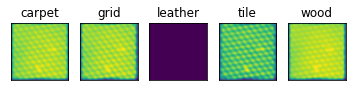

In [59]:
plt.figure()
for i in range(len(CLASSES)):
    plt.subplot(151+i)
    plt.imshow(Y[0, :, :, i])
    plt.title(CLASSES[i])
    plt.xticks([])
    plt.yticks([])

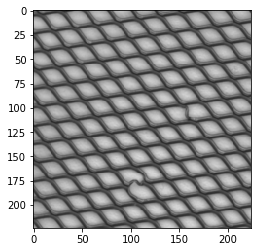

In [60]:
plt.imshow(test_input[test_idx][defect_idx][0])

## Thresholding grad-cam activations to get pixel level defect classification

In [61]:
class_idx = 4 #[carpet = 0, grid = 1, leather = 2, tile = 3, wood = 4]
for k in range(len(Y)):
    Y[k,:,:,class_idx] = Y[k,:,:,class_idx]/np.amax(Y[k,:,:,class_idx])
    for i in range(224):
        for j in range(224):
            if(i<=200 and i>=20 and j<=200 and j>=20):
                if Y[k,i,j,class_idx] > 0.95 or Y[k,i,j,class_idx] <0.05:
                    Y[k,i,j,class_idx]=1
                else:
                    Y[k,i,j,class_idx]=0
            else:
                Y[k,i,j,class_idx]=0

print(len(Y))
print(len(test_input[test_idx][defect_idx]))

37
37


In [62]:
defect_map = np.zeros([len(test_input[test_idx]),224,224])
defect_map[defect_idx] = Y[:,:,:, class_idx]

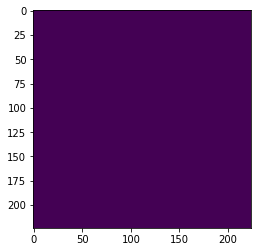

In [71]:
plt.imshow(defect_map[0])

## Getting ground truth defect segmentation and create blank images for good texture images

In [107]:
DATASET_ROOT = 'data/ground_truth'
GT_ROOT = 'data/ground_truth'
CLASSES = ['carpet', 'grid', 'leather', 'tile', 'wood']
##CLASSES = 'leather'
gt_datagen = ImageDataGenerator(rescale=1./255)
gt_generator = gt_datagen.flow_from_directory(DATASET_ROOT,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=(224, 224),
                                                    batch_size=382,
                                                    shuffle=False,
                                                    classes=CLASSES)
unique, counts = np.unique(gt_generator.labels, return_counts=True)
print(dict(zip(CLASSES, counts)))

Found 382 images belonging to 5 classes.
{'leather': 92, 'wood': 60, 'tile': 84, 'carpet': 89, 'grid': 57}


In [108]:
grd_truth,y = gt_generator.next()
print(grd_truth.shape)

(382, 224, 224, 3)


In [109]:
gt_carpet_idx = np.full(len(gt_generator.filenames),False)
gt_grid_idx = np.full(len(gt_generator.filenames),False)
gt_leather_idx = np.full(len(gt_generator.filenames),False)
gt_tile_idx = np.full(len(gt_generator.filenames),False)
gt_wood_idx = np.full(len(gt_generator.filenames),False)       
for i in range(len(gt_generator.filenames)):
    for j in range(len(gt_generator.filenames[i])):
        if gt_generator.filenames[i][j]== "/":
            break
    correct_class = gt_generator.filenames[i][0:j]
    if correct_class == "carpet":
        gt_carpet_idx[i] = True
    if correct_class == "grid":
        gt_grid_idx[i] = True
    if correct_class == "leather":
        gt_leather_idx[i] = True
    if correct_class == "tile":
        gt_tile_idx[i] = True
    if correct_class == "wood":
        gt_wood_idx[i] = True

In [110]:
print(len(grd_truth[gt_carpet_idx]))
print(len(grd_truth[gt_grid_idx]))
print(len(grd_truth[gt_leather_idx]))
print(len(grd_truth[gt_tile_idx]))
print(len(grd_truth[gt_wood_idx]))

89
57
92
84
60


## Creating blank images for good texture images

In [152]:
gt_images = np.zeros([len(test_input[test_idx]),224,224])
k = 0
for i in range(len(np.array(test_generator.filenames)[test_idx])):
    if "good" not in np.array(test_generator.filenames)[test_idx][i]:
        gt_images[i,:,:] = grd_truth[gt_wood_idx][k,:,:,0]#########edit class name
        k = k+1

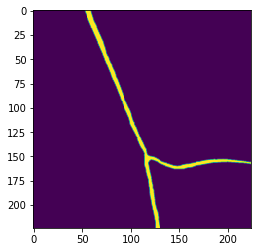

In [126]:
plt.imshow(gt_images[0])

## Caclulate I-o-U for one class 

In [153]:
intersection = np.logical_and(gt_images, defect_map)
union = np.logical_or(gt_images, defect_map)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.11027669813066815


In [ ]:
leather = 0.03909401,carpet = 0.07697287, grid=0.00361079, tile = 0.07505835, wood = 0.1102766981

## ---------------------Run till this part for each class by editing the class name in train_idx and test_idx -----------------##

## Getting overall defect test accuracy

**Get defect predictions for all classes and then run this**

In [160]:
correct = 0;
for i in range(len(defect_grdtruth)):
    if defect_grdtruth[i] == defect_result[i]:
        correct = correct + 1
accuracy = correct/len(defect_grdtruth)
print(accuracy*100)

67.18446601941747


## Dimensionality reduction to visualize learned features in train and test data

In [57]:
train_idx = train_carpet_idx ###choose class here 
test_idx = test_carpet_idx ###choose class here 

In [58]:
layer_activation_model = models.Model(inputs=model.input, outputs=model.layers[7].output)##Choosing topmost layer here
layer_output = layer_activation_model.predict(np.append(train_input[train_idx],test_input[test_idx],axis=0))

In [59]:
layer_out_vec = np.reshape(layer_output,(len(layer_output),56*56*256))
print(layer_out_vec.shape)

(397, 802816)


In [60]:
#pca = PCA(n_components=50, random_state=145)

pca = KernelPCA(n_components=50, random_state=145, kernel='rbf')
pca_features = pca.fit_transform(layer_out_vec)
pca_features.shape

(397, 50)

In [63]:
final_proj = TSNE(n_components=2, random_state=123).fit_transform(pca_features)
final_proj.shape
#train_proj = TSNE(n_components=2, random_state=123).fit_transform(tr_layer_out_vec)
#print(train_proj.shape)
#test_proj = TSNE(n_components=2, random_state=123).fit_transform(te_layer_out_vec)
#print(test_proj.shape)

(397, 2)

In [64]:
train_proj = final_proj[0:len(train_input[train_idx]),:]
test_proj = final_proj[len(train_input[train_idx]):(len(test_input[test_idx])+len(train_input[train_idx])),:]
#print(train_proj.shape)
#print(test_proj.shape)

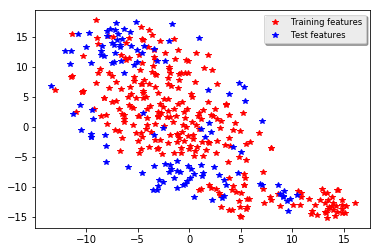

In [65]:
fig, ax = plt.subplots()
ax.plot(train_proj[:,0], train_proj[:,1], 'k*', label='Training features',color = 'red')
ax.plot(test_proj[:,0], test_proj[:,1], 'k*', label='Test features',color = 'blue')
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
plt.show()


## Run this visualize the full test dataset

In [13]:
test_idx = np.full(len(test_generator.filenames),True)

In [15]:
layer_activation_model = models.Model(inputs=model.input, outputs=model.layers[7].output)##Choosing topmost layer here
layer_output = layer_activation_model.predict(test_input[test_idx])####edittttt

In [ ]:
layer_out_vec = np.reshape(layer_output,(len(layer_output),56*56*256))
print(layer_out_vec.shape)

In [17]:
#pca = PCA(n_components=50, random_state=145)

pca = KernelPCA(n_components=50, random_state=145, kernel='rbf')
pca_features = pca.fit_transform(layer_out_vec)
pca_features.shape

(515, 50)

In [18]:
final_proj = TSNE(n_components=2, random_state=123).fit_transform(pca_features)
final_proj.shape
#train_proj = TSNE(n_components=2, random_state=123).fit_transform(tr_layer_out_vec)
#print(train_proj.shape)
#test_proj = TSNE(n_components=2, random_state=123).fit_transform(te_layer_out_vec)
#print(test_proj.shape)

(515, 2)

In [21]:
test_carpet_proj = final_proj[test_carpet_idx]
test_grid_proj = final_proj[test_grid_idx]
test_leather_proj = final_proj[test_leather_idx]
test_tile_proj = final_proj[test_tile_idx]
test_wood_proj = final_proj[test_wood_idx]

#print(train_proj.shape)
#print(test_proj.shape)##editttttt

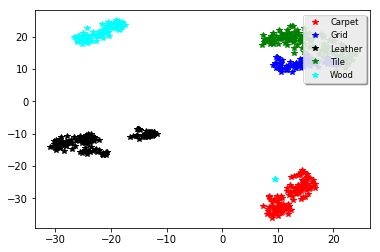

In [23]:
fig, ax = plt.subplots()
ax.plot(test_carpet_proj[:,0], test_carpet_proj[:,1], 'k*', label='Carpet',color = 'red')
ax.plot(test_grid_proj[:,0], test_grid_proj[:,1], 'k*', label='Grid',color = 'blue')
ax.plot(test_leather_proj[:,0], test_leather_proj[:,1], 'k*', label='Leather',color = 'black')
ax.plot(test_tile_proj[:,0], test_tile_proj[:,1], 'k*', label='Tile',color = 'green')
ax.plot(test_wood_proj[:,0], test_wood_proj[:,1], 'k*', label='Wood',color = 'cyan')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
plt.show()